Using device: cuda


/tmp/ipykernel_41355/3890168173.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../ResNet_parameters/resnet50_trained_parameters.pth')

Mass components in system: [None]
ATTENTION: the lens_grid must be the same provided during training. In the future, this will be forced somehow.


Creating sensitivity map: 100%|██████████| 30/30 [02:43<00:00,  5.46s/it]


Sensitivity map analysis complete!


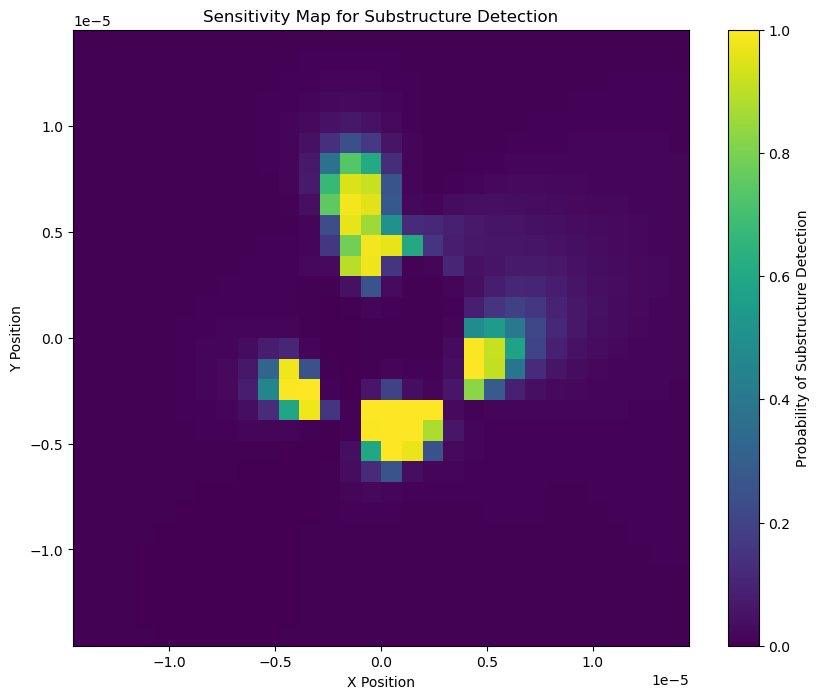

In [3]:
import torch
from lensing_system import LensingSystem
from deep_learning import ResNet50
from catalog_manager import CatalogManager
from sensitivity_map import SensitivityMapMaker
from shared_utils import _grid_lens

# 1. Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Create or load a lens grid (must match training grid)
grid_size = 100
grid_extent = 6.0  # arcseconds
lens_grid = _grid_lens(grid_extent, grid_size, device=device)

# 3. Load a pretrained ResNet model
model = ResNet50(num_classes=2)
model = model.to(device).double()
model.load_state_dict(torch.load('../ResNet_parameters/resnet50_trained_parameters.pth'))
model.eval()

# 4. Load a catalog and get a lensing system
catalog = CatalogManager(catalog_name_input="reposition_sources_test.json")
system_index = 7  # Choose which system to analyze
system_dict = catalog.catalog["SL_systems"][system_index]

redshift_lens=system_dict["lens_model"]["mass_components"][0]["params"]["redshift"]


substructure_dict = {
    "type": "NFW",
    "is_substructure": True,
    "params": {
        "pos": torch.tensor([0.0, 0.0], device=device),
        "mass_max": 1000000000.0, #10000000000.0, original training
        "r_max_kpc": 1.0,
        "redshift": redshift_lens
    }
}

# You may also want to add debugging to check your system structure:
print(f"Mass components in system: {[comp.get('mass_type') for comp in system_dict['lens_model']['mass_components']]}")

# 6. ResNet parameters (if any specific ones needed)
resnet_params = {
    "image_size": grid_size,
    "num_classes": 2
}


# Then create the sensitivity map maker:
sensitivity_map_maker = SensitivityMapMaker(
    image_dict=system_dict,
    substructure_to_test_dict=substructure_dict,
    lens_grid=lens_grid,
    ResNet_obj=model,
    ResNet_params=resnet_params
)

# And generate with more error handling:
# try:
#     sensitivity_map = sensitivity_map_maker.create_sensitivity_map(resolution=resolution)
# except Exception as e:
#     print(f"Error creating sensitivity map: {e}")
#     # Optionally inspect system structure for debugging
#     if hasattr(sensitivity_map_maker, 'image_dict') and 'lens_model' in sensitivity_map_maker.image_dict:
#         print("System structure:")
#         print(f"- Has precomputed: {'precomputed' in sensitivity_map_maker.image_dict}")
#         print(f"- Mass components: {len(sensitivity_map_maker.image_dict['lens_model'].get('mass_components', []))}")



# 8. Generate the sensitivity map (adjust resolution as needed)
resolution = 30  # Higher resolution = more detailed map but slower computation
sensitivity_map = sensitivity_map_maker.create_sensitivity_map(resolution=resolution)

# 9. Visualize the map
fig = sensitivity_map_maker.plot_sensitivity_map(sensitivity_map, resolution=resolution)

# 10. Save the sensitivity map and visualization
sensitivity_map_maker.save_sensitivity_map("sensitivity_map.npy", sensitivity_map)
fig.savefig("sensitivity_map.png", dpi=300, bbox_inches='tight')

print("Sensitivity map analysis complete!")

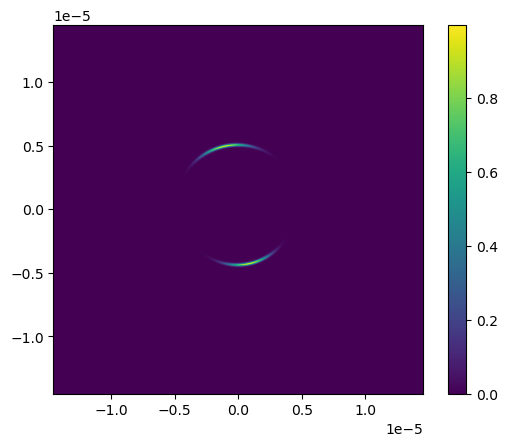

In [5]:
# Now show the imagefrom catalog_manager import CatalogManager
import json
from lensing_system import LensingSystem
from shared_utils import recursive_to_tensor, _grid_lens, _plot2D_on_grid
from matplotlib import pyplot as plt

device="cuda"

grid = _grid_lens(6, 1000, device=device)


my_catalog = CatalogManager(catalog_name_input="reposition_sources_test")
one_image_dict=my_catalog.catalog["SL_systems"][7]
one_image_dict=recursive_to_tensor(one_image_dict, device=device)
#print(json.dumps(one_image_dict, indent=4))
lensing_system=LensingSystem(one_image_dict, device=device)
image=lensing_system(grid)
plt.imshow(image.cpu().detach().numpy())
_plot2D_on_grid(plotted_data=image.cpu(), grid=grid)